In [1]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
# file that will be skipped because of information loss
zeros_test = ['co2a0000368_91.csv', 'co2c0000341_26.csv']
zeros_train = ['co2a0000368_0.csv', 'co2a0000368_1.csv', 'co2a0000368_2.csv', 'co2a0000368_3.csv', 'co2a0000368_4.csv', 'co2a0000368_5.csv', 'co2c0000341_27.csv']

### Menghitung Matriks Cumulant orde ke-3

In [18]:
def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contour plots
    # plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    # plt.xlabel('f1')
    # plt.ylabel('f2')
    # plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(bs.freq, bs.freq)
    ax.plot_surface(X, Y, bs.bispec_mag)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_zlabel('Bispectrum')
    plt.show()

    return bs.bispec_mag

### Persiapan data

In [4]:
# Define sampling frequency
fs = 256
t = np.arange(0, 1, 1/fs)

def get_csv_EEG(filename):
    # Load data from CSV
    data = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=range(3,259))
    channel_name = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=1, dtype='str', encoding='utf-8')
    
    df_data = pd.DataFrame(data.T, columns=channel_name)

    df_data = df_data.drop(columns=['X', 'Y', 'nd'])

    return df_data, df_data.columns


### Perhitungan Bispectrum

In [16]:
def extract_feature(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(directory.replace('CSV', 'bispectrum')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                if filename in zeros_train or filename in zeros_test:
                    continue
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                des_file = foldername+'_'+ str(trial_number) + '_bispectrum' +'.npy'
                if not os.path.exists(des_dir):
                    os.makedirs(des_dir)
                des_path = os.path.join(des_dir, des_file)
                if os.path.exists(des_path):
                    continue
                df_data, channel_name = get_csv_EEG(rel_path)
                bispectrum = []
                for channel in channel_name:
                    magnitude = calcCumulantOrde3(df_data[channel], t, 256)
                    bispectrum.append(magnitude)
                bispectrum = np.array(bispectrum)
                bispectrum = bispectrum[:,:256,:256]
                np.save(des_path, bispectrum)
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
        


### Main Program

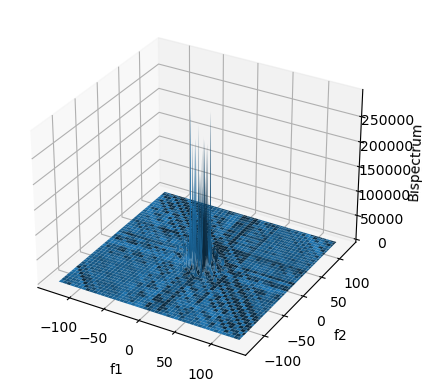

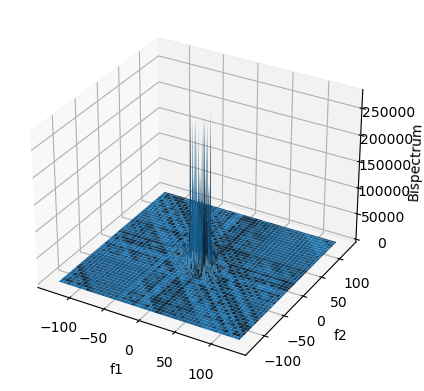

KeyboardInterrupt: 

In [19]:
lags = [256, 128, 64, 32, 16, 8, 4, 2]
for lag in [256]:
    extract_feature('../SMNI_CMI_TEST_CSV', lag)
    extract_feature('../SMNI_CMI_TRAIN_CSV', lag)

In [15]:
data = np.loadtxt('../out.csv', delimiter=",", skiprows=1, usecols=range(3,259))
channel_name = np.loadtxt('../out.csv', delimiter=",", skiprows=1, usecols=1, dtype='str', encoding='utf-8')

df_data = pd.DataFrame(data.T, columns=channel_name)
df_data = df_data.drop(columns=['X', 'Y', 'nd'])
bispectrum = []
for channel in df_data.columns:
    magnitude = calcCumulantOrde3(df_data[channel], t, 256)
    bispectrum.append(magnitude)
bispectrum = np.array(bispectrum)
np.save('../bispectrum.npy', bispectrum)
x = np.load('../bispectrum.npy')

(bispectrum == x).all()

True